# Recidivism in Georgia

In [541]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import re
import shap

from scipy.stats import pearsonr, norm
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.utils import resample

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate


## Dataset analysis

In [542]:
# Loading the dataset
df = pd.read_csv('exam_data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')

# Renaming columns
df = df.rename(columns={
    'Prior_Conviction_Episodes_Felony': 'Prior_Conviction_Felony',
    'Prior_Conviction_Episodes_Misd': 'Prior_Conviction_Misd',
    'Prior_Conviction_Episodes_Viol': 'Prior_Conviction_Viol',
    'Prior_Conviction_Episodes_Prop': 'Prior_Conviction_Prop',
    'Prior_Conviction_Episodes_Drug': 'Prior_Conviction_Drug',
    'Prior_Conviction_Episodes_PPViolationCharges': 'Prior_Conviction_PPViolation',
    'Prior_Conviction_Episodes_DomesticViolenceCharges': 'Prior_Conviction_DVCharges',
    'Prior_Conviction_Episodes_GunCharges': 'Prior_Conviction_GunCharges'
    
    })

# Target is whether or not they reoffend
target=df['Recidivism_Within_3years']

# Protected features
grouprace=df['Race']
groupsex=df['Gender']

# Split immedeatly to avoid leaking from dataset
# First split: temporary and test set
X_train, X_test, y_train, y_test, grouprace_train, grouprace_test, groupsex_train, groupsex_test = train_test_split(
    df, target, grouprace, groupsex, test_size=0.2, random_state=22)


## Demographic of offenders

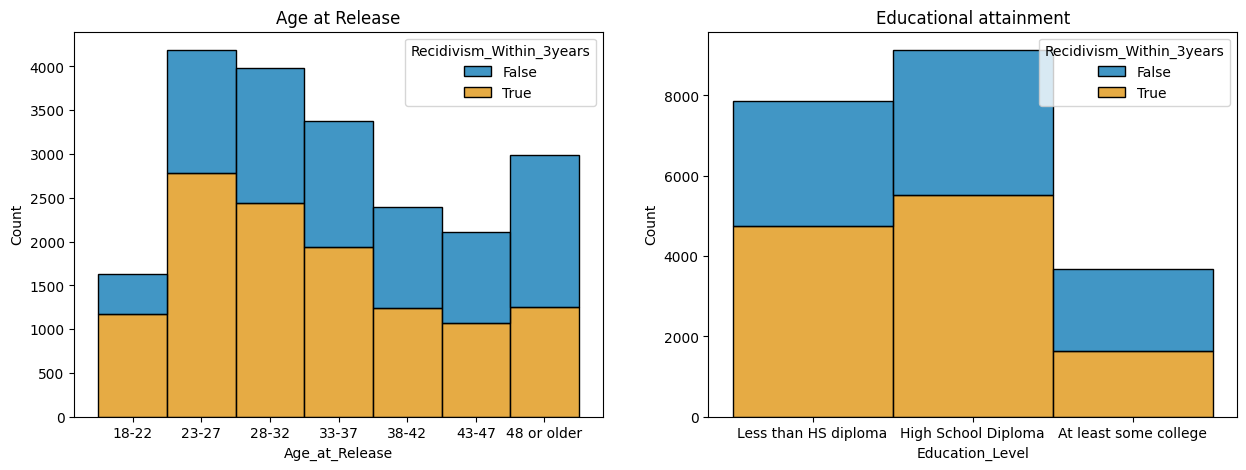

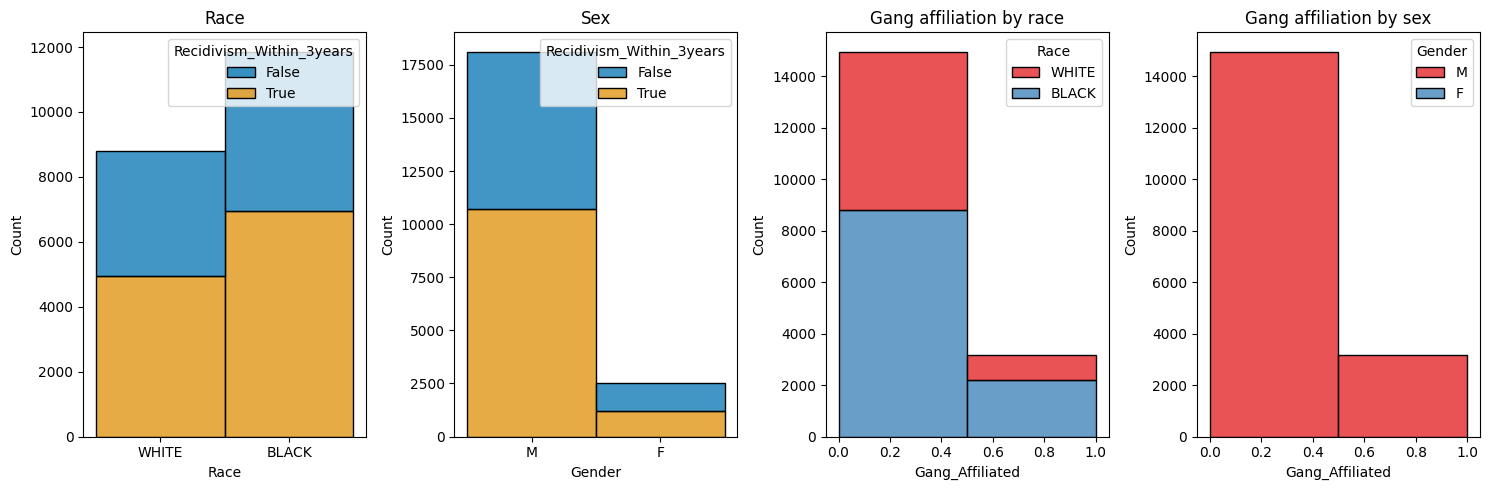

In [543]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

sns.histplot(x='Age_at_Release', data=X_train.sort_values(by='Age_at_Release'), hue='Recidivism_Within_3years', bins=5, ax=axes[0], multiple='stack',palette='colorblind')
axes[0].set_title('Age at Release')

X_train['Education_Level'] = pd.Categorical(X_train['Education_Level'], ['Less than HS diploma', 'High School Diploma', 'At least some college'])
sns.histplot(data=X_train, x='Education_Level', bins=3, ax=axes[1], hue='Recidivism_Within_3years', multiple='stack',palette='colorblind')
axes[1].set_title('Educational attainment')

fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Recidivism

sns.histplot(x='Race', data=X_train, ax=axes[0], bins=2, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[0].set_title('Race')

sns.histplot(x='Gender', data=X_train, ax=axes[1], bins=2, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[1].set_title('Sex')
sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[2], bins=2, palette='Set1', hue='Race', multiple='stack')
axes[2].set_title('Gang affiliation by race')


sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[3], bins=2, palette='Set1', hue='Gender', multiple='stack')
axes[3].set_title('Gang affiliation by sex')
# The Gang affiliation values for females are NaN!

plt.tight_layout()

In [544]:
# Chekcing for missing female gang affiliation values
print(X_train.groupby(['Gender', 'Gang_Affiliated']).size())
print(X_train.groupby(['Gender']).size())

Gender  Gang_Affiliated
M       False              14961
        True                3164
dtype: int64
Gender
F     2543
M    18125
dtype: int64


## Age, group and type of offense

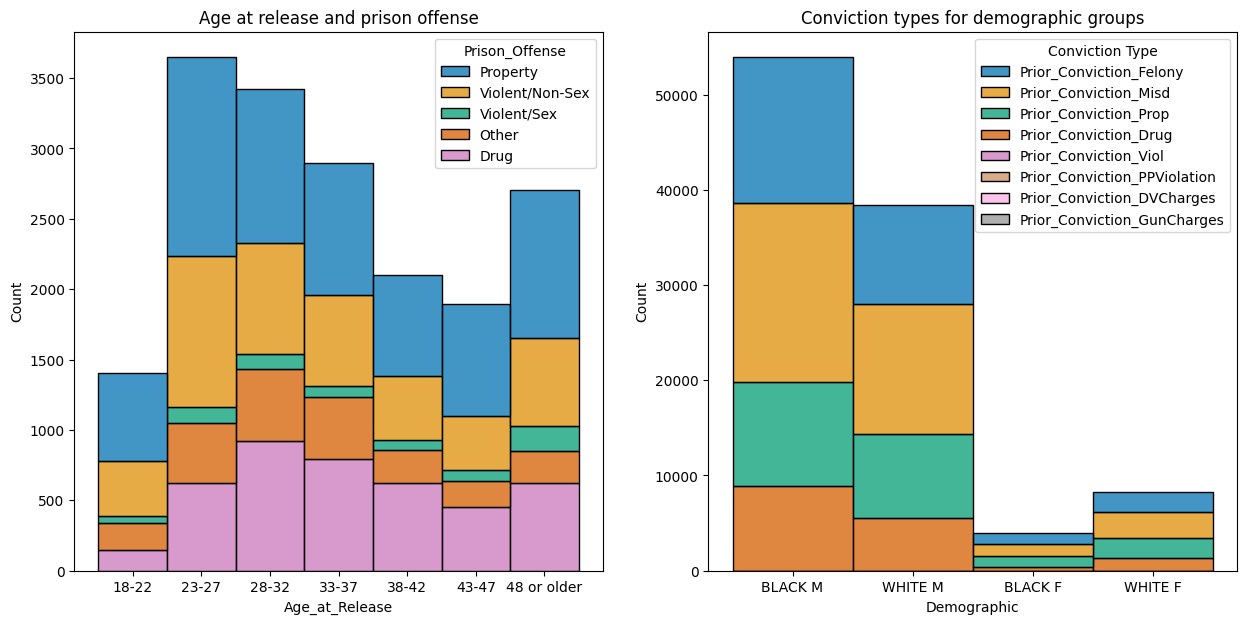

In [545]:
# Combine Race and Gender into single label
X_train['Demographic'] = X_train['Race'].astype(str) + ' ' + X_train['Gender'].astype(str)

# Conviction columns
conviction_cols = [
    'Prior_Conviction_Felony',
    'Prior_Conviction_Misd',
    'Prior_Conviction_Prop',
    'Prior_Conviction_Drug',
    'Prior_Conviction_Viol',
    'Prior_Conviction_PPViolation',
    'Prior_Conviction_DVCharges',
    'Prior_Conviction_GunCharges'
]

# Melt DataFrame
df_convictions = X_train[conviction_cols + ['Demographic']].copy()
df_melted = df_convictions.melt(
    id_vars='Demographic',
    value_vars=conviction_cols,
    var_name='Conviction Type',
    value_name='Count'
)

# Convert string values like '3 or more' to integer
df_melted['Count'] = df_melted['Count'].apply(
    lambda x: int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0
)

# Set demographic order 
demographic_order = ['BLACK M', 'WHITE M', 'BLACK F', 'WHITE F']
df_melted['Demographic'] = pd.Categorical(df_melted['Demographic'], categories=demographic_order, ordered=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Age at Release
sns.histplot(x='Age_at_Release', data=X_train.sort_values(by='Age_at_Release'), hue='Prison_Offense', bins=5, ax=axes[0], multiple='stack', palette='colorblind')
axes[0].set_title('Age at release and prison offense')

# Convictions stacked by type per demographic group
sns.histplot(data=df_melted, x='Demographic', weights='Count', hue='Conviction Type', multiple='stack', ax=axes[1], palette='colorblind'
             )
axes[1].set_title('Conviction types for demographic groups')
axes[1].tick_params(axis='x')

# Dropping the temporary demographic column
X_train=X_train.drop(['Demographic'],axis=1)


## Risk score and recidivism

Short investigation of Risk score, we won't be fitting it in our model, but this gives us an idea of the feature.

Text(0.5, 1.0, 'Risk score and type of offense')

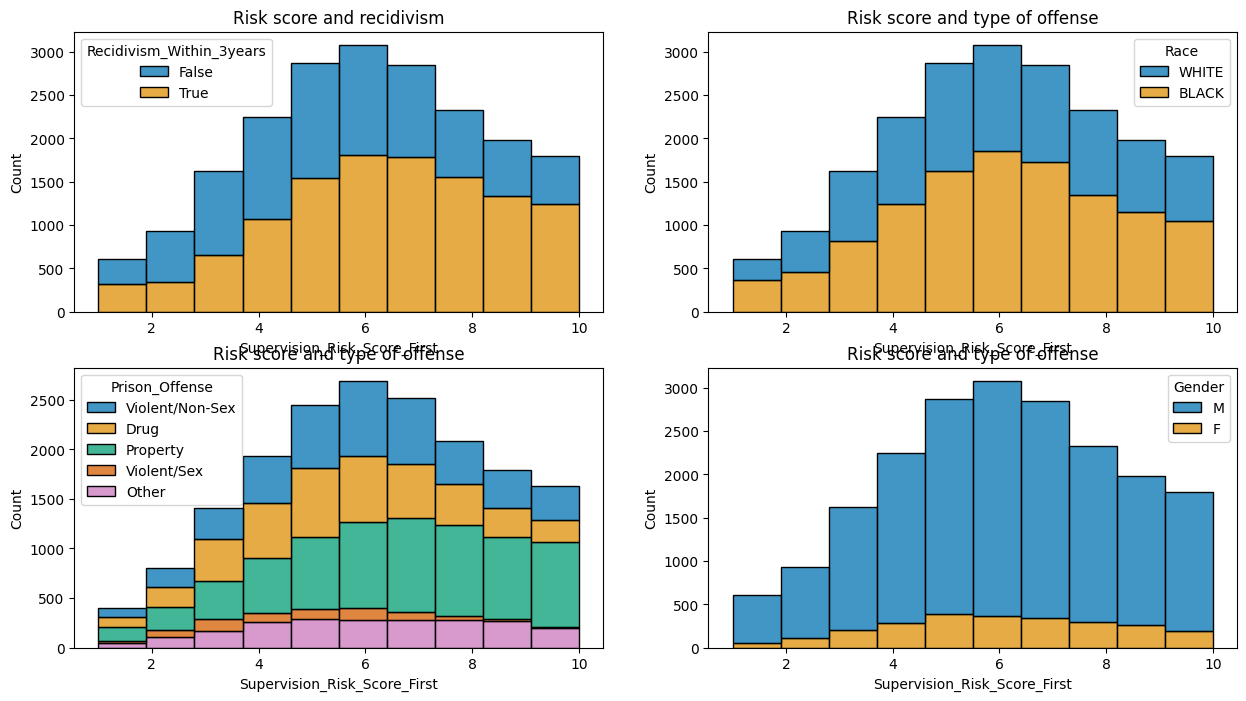

In [546]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))  

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,0], bins=10, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[0,0].set_title('Risk score and recidivism')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,0], bins=10, palette='colorblind', hue='Prison_Offense', multiple='stack')
axes[1,0].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,1], bins=10, palette='colorblind', hue='Race', multiple='stack')
axes[0,1].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,1], bins=10, palette='colorblind', hue='Gender', multiple='stack')
axes[1,1].set_title('Risk score and type of offense')

We will be dropping supervision risk score as a feature, since it is based on another classification model and we are unable to investigate what goes in to the given supervision risk score. Therefore we cannot guarantee that it is unbiased.

## Preprocessing
### Dropping and grouping columns

In [547]:
def preprocess_data(df):
    df_processed = df.copy()
    # Grouping drug data
    df_processed['DrugTest_Positive']=df_processed[['DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive']].any(axis=1)

    # Changing age scale categories to numerical data
    df_processed['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
    df_processed['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
    df_processed['Education_Level']=df['Education_Level'].replace(['Less than HS diploma','High School Diploma', 'At least some college'], [1,2,3])
    df_processed['Prison_Years']=df['Prison_Years'].replace(['Less than 1 year','1-2 years','Greater than 2 to 3 years','More than 3 years'],[1,2,3,4])

    # Representing the groups as binary, and renaming gender to sex (since the correct class in this case is sex)
    df_processed['Race']=df['Race'].replace(['WHITE','BLACK'],[1,0])
    df_processed['Sex']=df['Gender'].replace(['M','F'],[1,0])

    
    ## Handling NaN values
    # Assuming no information of gang affiliation equals no gang affiliation
    df_processed['Gang_Affiliated']=df['Gang_Affiliated'].fillna(0).astype(int)

    # Assuming no information for days per drug test means rare/never test (could potentially be better modelled categorical)
    df_processed['Avg_Days_per_DrugTest']=df['Avg_Days_per_DrugTest'].fillna(365*3).astype(int) 

    # Assuming no data on jobs does not necessarily mean unemployment, therefore filling NaN with mean value 
    df_processed['Percent_Days_Employed']=df['Percent_Days_Employed'].fillna(df['Percent_Days_Employed'].mean()).astype(int)
    df_processed['Jobs_Per_Year']=df['Jobs_Per_Year'].fillna(df['Jobs_Per_Year'].mean()).astype(int)

    ## Dropping columns 
    # Grouped data and the target is dropped
    # Assume arrest data is potentially biased (dependent on the police officer) and arrest \neq convicted
    # No knowledge on how supervision risk score/level is generated, (not clear which algorithm is used to generate it)
    df_processed=df_processed.drop(['Gender','ID','Residence_PUMA','Prior_Arrest_Episodes_Felony',
        'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
        'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
        'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Arrest_Episodes_DVCharges', 
        'Prior_Arrest_Episodes_GunCharges','Program_UnexcusedAbsences','Prior_Revocations_Parole',
        'Prior_Revocations_Probation','DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive','Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3',
         'Training_Sample', 'Recidivism_Within_3years', 'Supervision_Risk_Score_First', 'Supervision_Level_First'], axis=1)

    # Make string-numerical data numerical
    def extract_number(val):
        val_str = str(val) # ensure string
        match = re.search(r'\d+', val_str) # find value in string
        return int(match.group()) if match else pd.NA # return value

    # Features with string values converted
    ## (obs values like '3 or more' is thus converted to numerical value 3)
    cols = ['Dependents', 'Prior_Conviction_Felony', 'Prior_Conviction_Misd', 'Prior_Conviction_Prop',
        'Prior_Conviction_Drug','Delinquency_Reports', 'Program_Attendances', 'Residence_Changes']
    df_processed[cols] = df_processed[cols].applymap(extract_number).astype('Int64')

    # One hot encoding the boolean value prison offence 
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=['Prison_Offense'], drop_first=True)

    # Rearranging the dataframe to have protected features first
    first_columns = ['Sex', 'Race']
    remaining_columns = [col for col in df_processed.columns if col not in first_columns]
    df_processed = df_processed[first_columns + remaining_columns]

    return df_processed

# Avoid leakage by preprocessing seperately
X_train=preprocess_data(X_train)
X_test=preprocess_data(X_test)

features=X_train.columns

# Standardizing all features
scaler = StandardScaler().fit(X_train.astype(float))
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_32744\2050904828.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
C:\Users\Bruger\AppData\Local\Temp\ipykernel_32744\2050904828.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
C:\Users\Bruger\AppData\Local\Temp\ipyke

## Correlations

We mostly have numerical scale data and only binary categorical data, therefore we choose to look at pearson correlations. We looked into cramer correlations but should not be necessary for the way we scaled our data

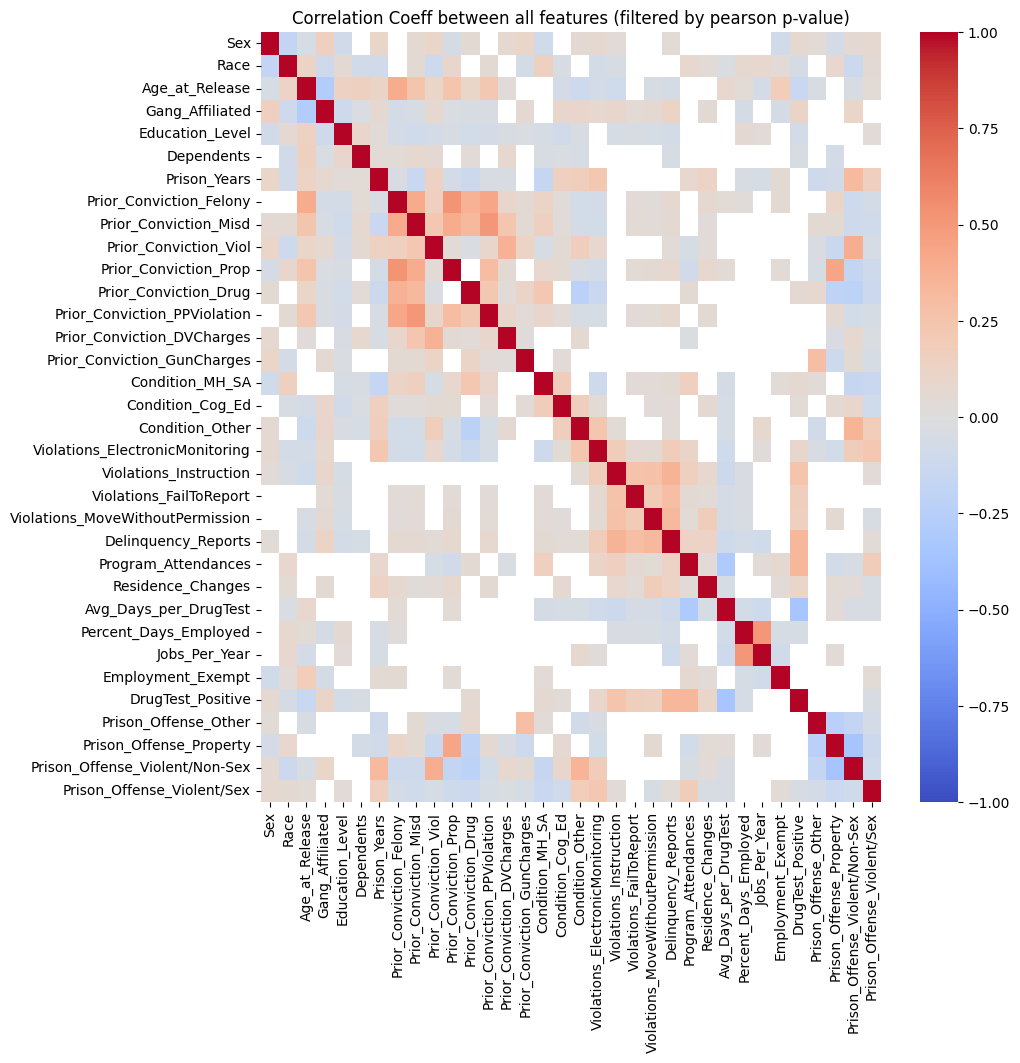

In [548]:
n_features = Xs_train.shape[1]
alpha = 0.05 # Significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# Compute p-value using pearson
corr_pearson = np.zeros((n_features, n_features))
p = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_pearson[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
        if np.isnan(corr_pearson[i,j]):
            p[i,j] = 1

plt.figure(figsize=(10,10))
sns.heatmap(corr_pearson, vmin=-1, vmax=1, cmap="coolwarm", xticklabels=features, yticklabels=features, mask= p > corrected_alpha) ## mask if p is higher
plt.title("Correlation Coeff between all features (filtered by pearson p-value)")
plt.show()

In [549]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# import math

# # Convert Xs_train to DataFrame for easier plotting
# df = pd.DataFrame(Xs_train, columns=features)

# protected_indices = [0, 1]  # Sex and Race columns

# significant_pairs = []
# for i in protected_indices:
#     for j in range(n_features):
#         if i != j and p[i, j] < corrected_alpha:
#             significant_pairs.append((i, j))

# n_plots = len(significant_pairs)
# n_cols = 2
# n_rows = math.ceil(n_plots / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
# axes = axes.flatten()

# for idx, (i, j) in enumerate(significant_pairs):
#     ax = axes[idx]
    
#     # If both features are categorical, use swarmplot for both axes (treating second as categorical)
#     # Otherwise, treat second feature as numeric on y-axis
#     if df[features[j]].nunique() < 10:  # heuristic for categorical
#         sns.swarmplot(x=features[i], y=features[j], data=df, ax=ax, alpha=0.7)
#     else:
#         sns.swarmplot(x=features[i], y=features[j], data=df, ax=ax, alpha=0.7)
    
#     ax.set_title(f"{features[i]} vs {features[j]}\n(p={p[i,j]:.1e}, r={corr_pearson[i,j]:.2f})")
#     ax.grid(True)

# # Remove any unused axes
# for k in range(len(significant_pairs), len(axes)):
#     fig.delaxes(axes[k])

# plt.tight_layout()
# plt.suptitle("Swarm Plots for Significant Correlations Involving Sex or Race", fontsize=16, y=1.02)
# plt.show()


We see quite a lot significant correlation, however many of which are numerically very small.

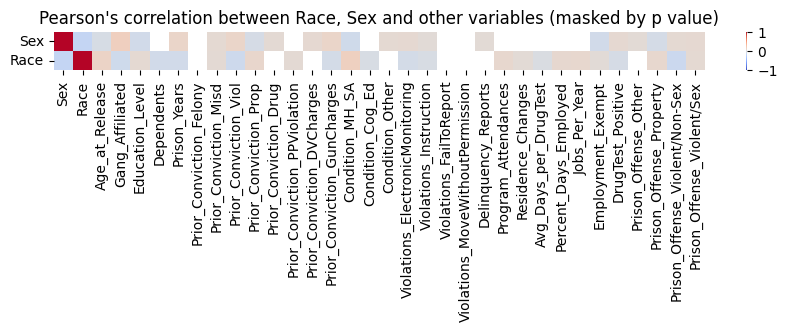

In [550]:
corr_pear = pd.DataFrame(corr_pearson, columns=features)
p_df = pd.DataFrame(p, columns=features, index=features)

plt.figure(figsize=(10.5,0.5))
sns.heatmap(corr_pear[['Sex','Race']].transpose(), vmin=-1,vmax=1, cmap="coolwarm",  yticklabels=['Sex','Race'], xticklabels=features,  mask = (p_df > corrected_alpha)[['Sex','Race']].transpose().values) #)  & (corr_pear_cramer > 0.005))[['Sex','Race']], vmin=-0.25, vmax=0.25)
plt.title("Pearson's correlation between Race, Sex and other variables (masked by p value)")
plt.show()

## Model fitting

In [551]:
# Saving a training dataset without the protected features
Xs_train_none = np.delete(Xs_train, [0,1], axis=1)
Xs_test_none = np.delete(Xs_test, [0,1], axis=1)

Xs_train_protected = Xs_train[:, [0, 1]]
Xs_test_protected = Xs_test[:, [0, 1]]

y_train=y_train.values
y_test=y_test.values


## Finetuning hyper parameters

This code can be uncommented to calculate best hyperparameters. Takes approx 10 minutes to run

In [552]:
## Logistic regression

# Xs_train is dense (scaled) -> therefore solver is lbfgs
# L2 for penalizing the SS of the weights 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_LR = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs'), param_grid, cv=5) #liblinear for binary 
grid_search_LR.fit(Xs_train_none, y_train)  

print("Best C:", grid_search_LR.best_params_['C'])
print("Best score:", grid_search_LR.best_score_)
C=grid_search_LR.best_params_['C']

# Will produce this result:
# C= 0.6795687135263339

## Random forest

rf = RandomForestClassifier(random_state=33, n_jobs=-1)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 5-fold CV grid search
grid_search_RF = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    #scoring='accuracy',   # or another metric like 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# Fit 
grid_search_RF.fit(Xs_train_none, y_train)

# Best combination
print("Best params:", grid_search_RF.best_params_)
print("Best CV score:", grid_search_RF.best_score_)

# Will produce this result:
# Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


Best C: 0.001
Best score: 0.6806176021264883
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6857463574184491


In [553]:
group_test_dict = {
    'Male': groupsex_test == 'M',
    'Female': groupsex_test == 'F',
    'White': grouprace_test == 'WHITE',
    'Black':  grouprace_test == 'BLACK'
}

# Fit LR model
baselineLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
baselineLR.fit(Xs_train_none, y_train)
#y_hatLR = baselineLR.predict(Xs_test_none.astype(float))


# Fit RF model
baselineRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

baselineRF.fit(Xs_train_none, y_train)
#y_hatRF = baselineRF.predict(Xs_test_none.astype(float))

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=33)

In [554]:
# Initialize dictionaries to store results for each group and metric
results = {
    'model': [],  
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],
    'f1': []
}

n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test_none[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': baselineLR.predict(X_bs),
        'RF': baselineRF.predict(X_bs)
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Summary by group and model
summary_by_group_model_baseline = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_baseline = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_baseline[(model, group)] = ci

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping: 100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


In [555]:
summary_by_group_model_baseline

tp        fp        tn       fn       tpr       fpr  \
model group                                                                
LR    Black    1464.828   664.580   547.111  310.579  0.825077  0.548474   
      Female    208.916   163.219   200.572   50.991  0.803792  0.448672   
      Male     2271.947   947.326   842.003  482.026  0.824977  0.529432   
      Overall  2480.863  1110.545  1042.575  533.017  0.823149  0.515783   
      White    1016.035   445.965   495.464  222.438  0.820398  0.473703   
RF    Black    1473.340   644.597   567.094  302.067  0.829865  0.531985   
      Female    205.146   149.075   214.716   54.761  0.789276  0.409802   
      Male     2294.321   926.420   862.909  459.652  0.833100  0.517751   
      Overall  2499.467  1075.495  1077.625  514.413  0.829321  0.499507   
      White    1026.127   430.898   510.531  212.346  0.828551  0.457691   

               accuracy        f1  
model group                        
LR    Black    0.673542  0.750221  
      Female   0.656560  0.660768  
      Male     0.685394  0.760680  
      Overall  0.681912  0.751148  
      White    0.693377  0.752425  
RF    Black    0.683080  0.756803  
      Female   0.673186  0.667741  
      Male     0.694919  0.767983  
      Overall  0.692296  0.758671  
      White    0.704920  0.761304

In [556]:
confidence_intervals_baseline

{('LR',
  'Overall'): {'tpr': (np.float64(0.8084660221403777),
   np.float64(0.8364073214840394)), 'fpr': (np.float64(0.4948044403572964),
   np.float64(0.5361306150940298)), 'accuracy': (np.float64(0.6700164505515773),
   np.float64(0.6947938842655312)), 'f1': (np.float64(0.7399535837184221),
   np.float64(0.7625129182934746))},
 ('LR',
  'Male'): {'tpr': (np.float64(0.8104586391161791),
   np.float64(0.8391074231213673)), 'fpr': (np.float64(0.5062803374329865),
   np.float64(0.5514666962603599)), 'accuracy': (np.float64(0.672367275753288),
   np.float64(0.6990616349201708)), 'f1': (np.float64(0.7494927444177416),
   np.float64(0.7726626565816344))},
 ('LR',
  'Female'): {'tpr': (np.float64(0.7588693613150135),
   np.float64(0.8514521059782608)), 'fpr': (np.float64(0.4009762607592143),
   np.float64(0.5025563056714398)), 'accuracy': (np.float64(0.617491851185793),
   np.float64(0.6939109848484848)), 'f1': (np.float64(0.6183397271952259),
   np.float64(0.7024612615156541))},
 ('LR',
  

# Evaluating metrics

We have code to calculate precision, recall, specificity, fpr, fnr, accuracy and f1 score. This gave us a greater understanding on model performance, however in our report we will discuss the metrics, we find the most important.

# Pre processing

In [557]:
# Functions from exercise solution lecture 10
# Decorrelation
def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased

# Debiasing recidivism data
Xs_train_none_debiased = debias_features(Xs_train_none, Xs_train_protected)
Xs_train_debiased = np.concatenate([Xs_train_none_debiased, Xs_train_protected], axis=1)

In [558]:
C= 0.6795687135263339 # from grid search
preprocessedLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
preprocessedLR.fit(Xs_train_none_debiased, y_train)

# Fit RF model
preprocessedRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

preprocessedRF.fit(Xs_train_none_debiased, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=33)

In [559]:
# Initialize dictionaries to store results for each group and metric
results = {
    'model': [], 
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],

    'f1': []
}

n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test_none[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': preprocessedLR.predict(X_bs),
        'RF': preprocessedRF.predict(X_bs)
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        #results['bootstrap_id'].append(i)
        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Summary by group and model
summary_by_group_model_pre = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_pre = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_pre[(model, group)] = ci

Bootstrapping: 100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


In [560]:
summary_by_group_model_pre

tp        fp        tn       fn       tpr       fpr  \
model group                                                                
LR    Black    1430.688   628.175   583.409  342.918  0.806648  0.518489   
      Female    203.755   153.513   210.886   56.306  0.783427  0.421280   
      Male     2213.978   881.804   908.658  538.100  0.804475  0.492501   
      Overall  2417.733  1035.317  1119.544  594.406  0.802662  0.480458   
      White     987.045   407.142   536.135  251.488  0.796948  0.431631   
RF    Black    1470.976   652.996   558.588  302.630  0.829366  0.538970   
      Female    214.712   164.602   199.797   45.349  0.825587  0.451700   
      Male     2305.391   937.328   853.134  446.687  0.837691  0.523512   
      Overall  2520.103  1101.930  1052.931  492.036  0.836649  0.511375   
      White    1049.127   448.934   494.343  189.406  0.847078  0.475946   

               accuracy        f1  
model group                        
LR    Black    0.674692  0.746562  
      Female   0.663988  0.659695  
      Male     0.687420  0.757162  
      Overall  0.684590  0.747894  
      White    0.698126  0.749757  
RF    Black    0.679874  0.754765  
      Female   0.663784  0.671264  
      Male     0.695321  0.769101  
      Overall  0.691510  0.759706  
      White    0.707427  0.766674

In [561]:
confidence_intervals_pre

{('LR',
  'Overall'): {'tpr': (np.float64(0.7882464206400377),
   np.float64(0.8164793720332566)), 'fpr': (np.float64(0.4581739192444219),
   np.float64(0.5019070549477619)), 'accuracy': (np.float64(0.6719566479581962),
   np.float64(0.697503386878266)), 'f1': (np.float64(0.7367755944782899),
   np.float64(0.7599856496218408))},
 ('LR',
  'Male'): {'tpr': (np.float64(0.7893388523700879),
   np.float64(0.8195007038429456)), 'fpr': (np.float64(0.46920354221923716),
   np.float64(0.5164954777523738)), 'accuracy': (np.float64(0.674719236054898),
   np.float64(0.7010909710525565)), 'f1': (np.float64(0.7450676187582012),
   np.float64(0.7695242961833608))},
 ('LR',
  'Female'): {'tpr': (np.float64(0.7330216777204619),
   np.float64(0.8327744755244755)), 'fpr': (np.float64(0.3711780240073869),
   np.float64(0.4746666666666667)), 'accuracy': (np.float64(0.6249952143950995),
   np.float64(0.6996943990515556)), 'f1': (np.float64(0.6148723292499026),
   np.float64(0.7033709417118597))},
 ('LR',
 

In [562]:
# explainerWB = shap.Explainer(baselineLR, Xs_train_none_debiased, model_output='probability')
# shap_valuesWB = explainerWB.shap_values(Xs_test_none)

# # Summary plot
# shap.summary_plot(shap_valuesWB[:], Xs_test_none, 
#                   feature_names=features[2:], 
#                   max_display=10, show=False)

# plt.title(f'Shap values logistic regression summary plot')
# plt.tight_layout()

# plt.show()

# ## Black box

# explainer = shap.TreeExplainer(baselineRF, Xs_train_none_debiased, model_output='probability')
# shap_values = explainer(Xs_test_none)

# # Summary plot
# shap.summary_plot(shap_values[:,:,1], Xs_test_none, 
#                   feature_names=features[2:], 
#                   max_display=10, show=False)

# plt.title(f'Shap values random forest summary plot')
# plt.tight_layout()
# plt.show()

# Postprocessing

In [563]:
## Logistic regression

# Xs_train is dense (scaled) -> therefore solver is lbfgs
# L2 for penalizing the SS of the weights 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_LR = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs'), param_grid, cv=5) #liblinear for binary 
grid_search_LR.fit(Xs_train, y_train)  

print("Best C:", grid_search_LR.best_params_['C'])
print("Best score:", grid_search_LR.best_score_)
C=grid_search_LR.best_params_['C']

# Will produce this result:
# C= 

## Random forest

rf = RandomForestClassifier(random_state=33, n_jobs=-1)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 5-fold CV grid search
grid_search_RF = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    #scoring='equalized odds',   
    n_jobs=-1,
    verbose=1
)

# Fit 
grid_search_RF.fit(Xs_train, y_train)

# Best combination
print("Best params:", grid_search_RF.best_params_)
print("Best CV score:", grid_search_RF.best_score_)

# Will produce this result:
# Best params: 

Best C: 0.001
Best score: 0.6832302595684305
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6872463262229936


In [564]:
# Fit LR model
postprocLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
postprocLR.fit(Xs_train, y_train)
#y_hatLR = baselineLR.predict(Xs_test_none.astype(float))


# Fit RF model
postprocRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

postprocRF.fit(Xs_train, y_train)

probs_LR = postprocRF.predict_proba(Xs_test)[:, 1]
probs_RF = postprocRF.predict_proba(Xs_test)[:, 1]


# Protected attributes
protected_attr_test = Xs_test_protected

#  Logistic Regression
postproc_LR = ThresholdOptimizer(
    estimator=postprocRF,
    constraints="equalized_odds",  # 
    predict_method='predict_proba',
    prefit=True,
    flip=False # We don't want to flip
)
postproc_LR.fit(Xs_test, y_test, sensitive_features=protected_attr_test)
#y_hatLR_post = postproc_LR.predict(Xs_test_none, sensitive_features=protected_attr_test)

# Fairlearn Postprocessing: Random Forest 
postproc_RF = ThresholdOptimizer(
    estimator=postprocRF,
    constraints="equalized_odds",  
    predict_method='predict_proba',
    prefit=True
)
postproc_RF.fit(Xs_test, y_test, sensitive_features=protected_attr_test)
#y_hatRF_post = postproc_RF.predict(Xs_test_none, sensitive_features=protected_attr_test)

# Initialize dictionaries to store results for each group and metric
results = {
    'model': [], 
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],
    'f1': []
}

n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': postproc_LR.predict(X_bs,sensitive_features=X_bs[:, [0, 1]]),
        'RF': postproc_RF.predict(X_bs,sensitive_features=X_bs[:, [0, 1]])
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        #results['bootstrap_id'].append(i)
        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)    
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Summary by group and model
summary_by_group_model_post = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_post = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_post[(model, group)] = ci

Bootstrapping: 100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s]


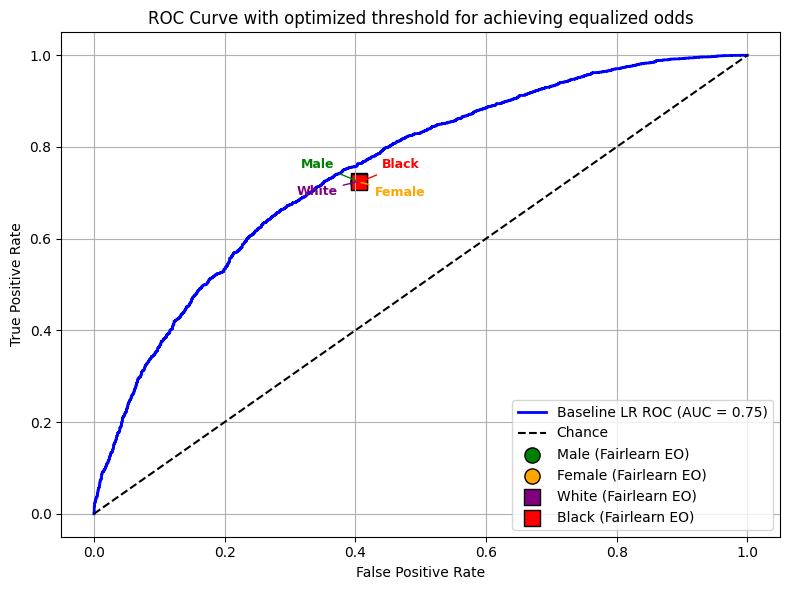

In [565]:
#ROC Curve from baseline LR
fpr, tpr, thresholds = roc_curve(y_test, probs_LR)
roc_auc = auc(fpr, tpr)

#Fairlearn post-processed FPR/TPR
group_roc_points = {
    'Male':   {'FPR': 0.405892, 'TPR': 0.723881, 'GroupType': 'Sex'},
    'Female': {'FPR': 0.404624, 'TPR': 0.724026, 'GroupType': 'Sex'},
    'White':  {'FPR': 0.405348, 'TPR': 0.725080, 'GroupType': 'Race'},
    'Black':  {'FPR': 0.405949, 'TPR': 0.723050, 'GroupType': 'Race'}
}

colors = {
    'Male': 'green',
    'Female': 'orange',
    'White': 'purple',
    'Black': 'red'
}

markers = {
    'Sex': 'o',
    'Race': 's'
}

#Annotation offsets, fanning out the annotations for readability
offsets = {
    'Male':   (-30, 10),
    'Female': (30, -10),
    'White':  (-30, -10),
    'Black':  (30, 10)
}

#Plot
plt.figure(figsize=(8, 6))

#Baseline ROC
plt.plot(fpr, tpr, label=f'Baseline LR ROC (AUC = {roc_auc:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

#Fairlearn post-processed group points
for group, coords in group_roc_points.items():
    x = coords['FPR']
    y = coords['TPR']
    ox, oy = offsets[group]
    plt.scatter(x, y,
                label=f'{group} (Fairlearn EO)',
                color=colors[group],
                s=120,
                marker=markers[coords['GroupType']],
                edgecolor='black')
    
    # Annotate with fanned-out offset
    plt.annotate(group,
                 (x, y),
                 textcoords="offset points",
                 xytext=(ox, oy),
                 ha='center',
                 arrowprops=dict(arrowstyle='-', color=colors[group]),
                 fontsize=9,
                 color=colors[group],
                 weight='bold')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with optimized threshold for achieving equalized odds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


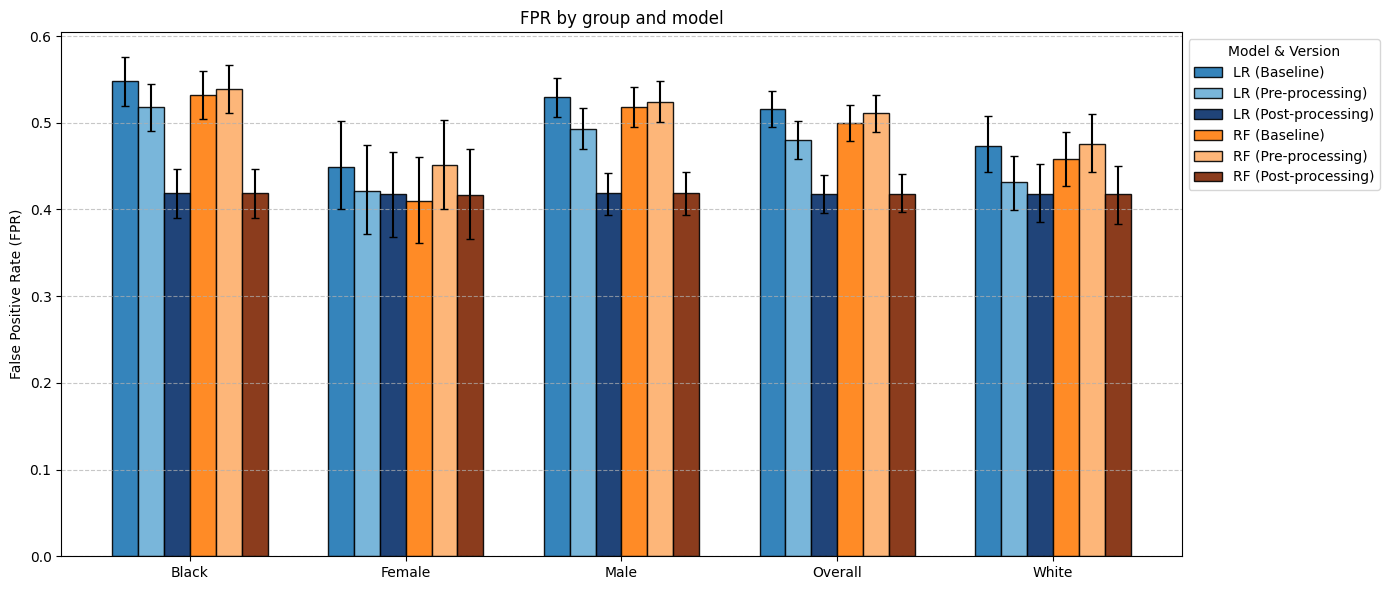

In [569]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Flatten all summary tables and tag with version
base_df = summary_by_group_model_baseline.reset_index()
base_df['version'] = 'Baseline'

pre_df = summary_by_group_model_pre.reset_index()
pre_df['version'] = 'Pre-processing'

post_df = summary_by_group_model_post.reset_index()
post_df['version'] = 'Post-processing'

# Combine all into one DataFrame
combined_df = pd.concat([base_df, pre_df, post_df], ignore_index=True)

# Define plotting structure
groups = combined_df['group'].unique()
models = ['LR', 'RF']
versions = ['Baseline', 'Pre-processing', 'Post-processing']

# Bar settings
x = np.arange(len(groups))
total_bars = len(models) * len(versions)
width = 0.12  # narrow for 6 bars per group

# Setup figure
fig, ax = plt.subplots(figsize=(14, 6))

# Color map
color_map = {
    ('LR', 'Baseline'): '#1f77b4',
    ('LR', 'Pre-processing'): '#6baed6',
    ('LR', 'Post-processing'): '#08306b',
    ('RF', 'Baseline'): '#ff7f0e',
    ('RF', 'Pre-processing'): '#fdae6b',
    ('RF', 'Post-processing'): '#7f2704',
}

# Confidence interval map
ci_map = {
    'Baseline': confidence_intervals_baseline,
    'Pre-processing': confidence_intervals_pre,
    'Post-processing': confidence_intervals_post,
}

# Plot loop
for i_model, model in enumerate(models):
    for i_version, version in enumerate(versions):
        offset = (i_model * len(versions) + i_version - total_bars / 2 + 0.5) * width
        means = []
        lower_err = []
        upper_err = []

        for group in groups:
            row = combined_df[
                (combined_df['model'] == model) &
                (combined_df['group'] == group) &
                (combined_df['version'] == version)
            ]

            fpr_mean = row['fpr'].values[0]
            ci_lower, ci_upper = ci_map[version][(model, group)]['fpr']
            means.append(fpr_mean)
            lower_err.append(fpr_mean - ci_lower)
            upper_err.append(ci_upper - fpr_mean)

        ax.bar(
            x + offset,
            means,
            width,
            label=f'{model} ({version})',
            color=color_map[(model, version)],
            yerr=[lower_err, upper_err],
            capsize=3,
            edgecolor='black',
            alpha=0.9
        )

# Formatting
ax.set_ylabel('False Positive Rate (FPR)')
ax.set_title('FPR by group and model')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend(title='Model & Version', bbox_to_anchor=(1, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


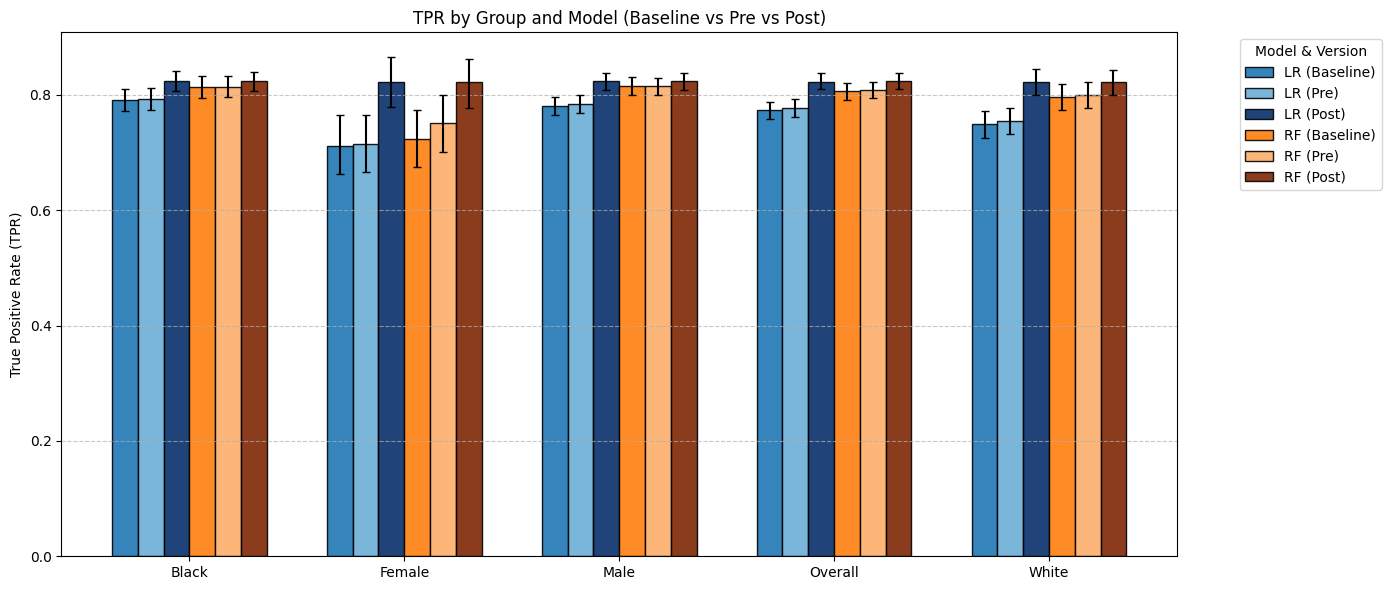

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))


# Plot each bar with TPR
for i_model, model in enumerate(models):
    for i_version, version in enumerate(versions):
        offset = (i_model * len(versions) + i_version - total_bars / 2 + 0.5) * width
        means = []
        lower_err = []
        upper_err = []

        for group in groups:
            row = combined_df[
                (combined_df['model'] == model) &
                (combined_df['group'] == group) &
                (combined_df['version'] == version)
            ]

            tpr_mean = row['tpr'].values[0]
            ci_lower, ci_upper = ci_map[version][(model, group)]['tpr']
            means.append(tpr_mean)
            lower_err.append(tpr_mean - ci_lower)
            upper_err.append(ci_upper - tpr_mean)

        ax.bar(
            x + offset,
            means,
            width,
            label=f'{model} ({version})',
            color=color_map[(model, version)],
            yerr=[lower_err, upper_err],
            capsize=3,
            edgecolor='black',
            alpha=0.9
        )

# Formatting
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('TPR by Group and Model (Baseline vs Pre vs Post)')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend(title='Model & Version', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Confusion matrices

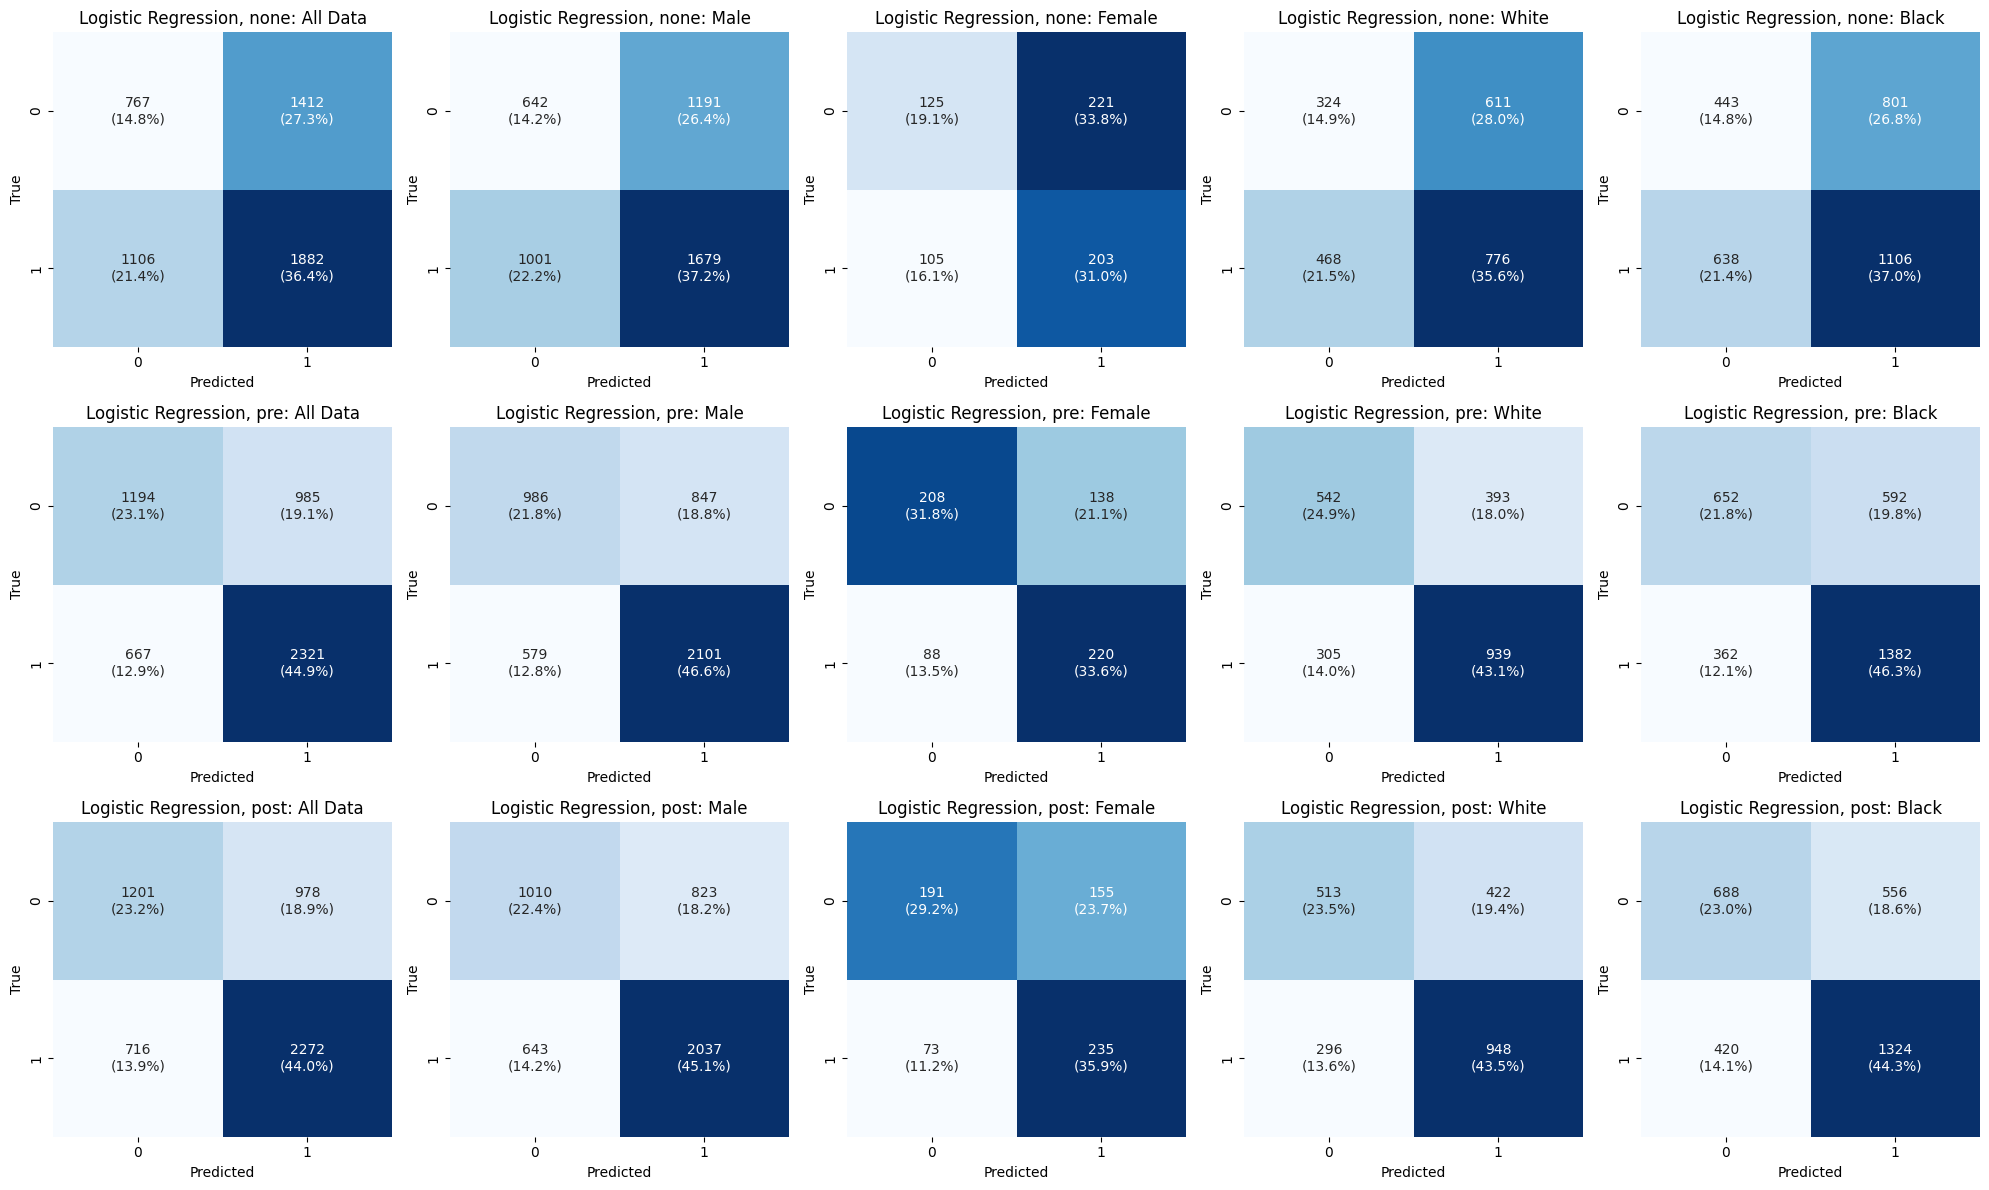

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect all stages
summary_data_dict = {
    'Baseline': summary_by_group_model_baseline,
    'Pre': summary_by_group_model_pre,
    'Post': summary_by_group_model_post
}

groups = ['Overall', 'Black', 'White', 'Male', 'Female']
models = ['LR', 'RF']
stages = ['Baseline', 'Pre', 'Post']

fig, axes = plt.subplots(
    nrows=len(groups),
    ncols=len(models) * len(stages),
    figsize=(18, 12),
    constrained_layout=True
)

# Loop over all combinations
for row_idx, group in enumerate(groups):
    for col_idx, stage in enumerate(stages):
        for model_idx, model in enumerate(models):
            col_pos = col_idx * len(models) + model_idx

            ax = axes[row_idx, col_pos]
            summary_df = summary_data_dict[stage]

            # Fetch confusion matrix values
            try:
                row = summary_df.loc[(model, group)]
                tp = row['tp']
                fp = row['fp']
                tn = row['tn']
                fn = row['fn']
            except KeyError:
                ax.axis('off')
                continue

            cm = np.array([[tn, fp], [fn, tp]])
            labels = np.array([['TN', 'FP'], ['FN', 'TP']])

            # Heatmap
            sns.heatmap(
                cm,
                annot=labels + "\n" + cm.astype(int).astype(str),
                fmt='',
                cmap='Blues',
                cbar=False,
                ax=ax,
                annot_kws={"size": 10},
                linewidths=0.5,
                square=True
            )

            # Titles
            ax.set_title(f'{model} ({stage})', fontsize=10)
            if col_pos == 0:
                ax.set_ylabel(group, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

# Master title
plt.suptitle("Confusion Matrices by Group, Model, and Stage", fontsize=16)
plt.show()


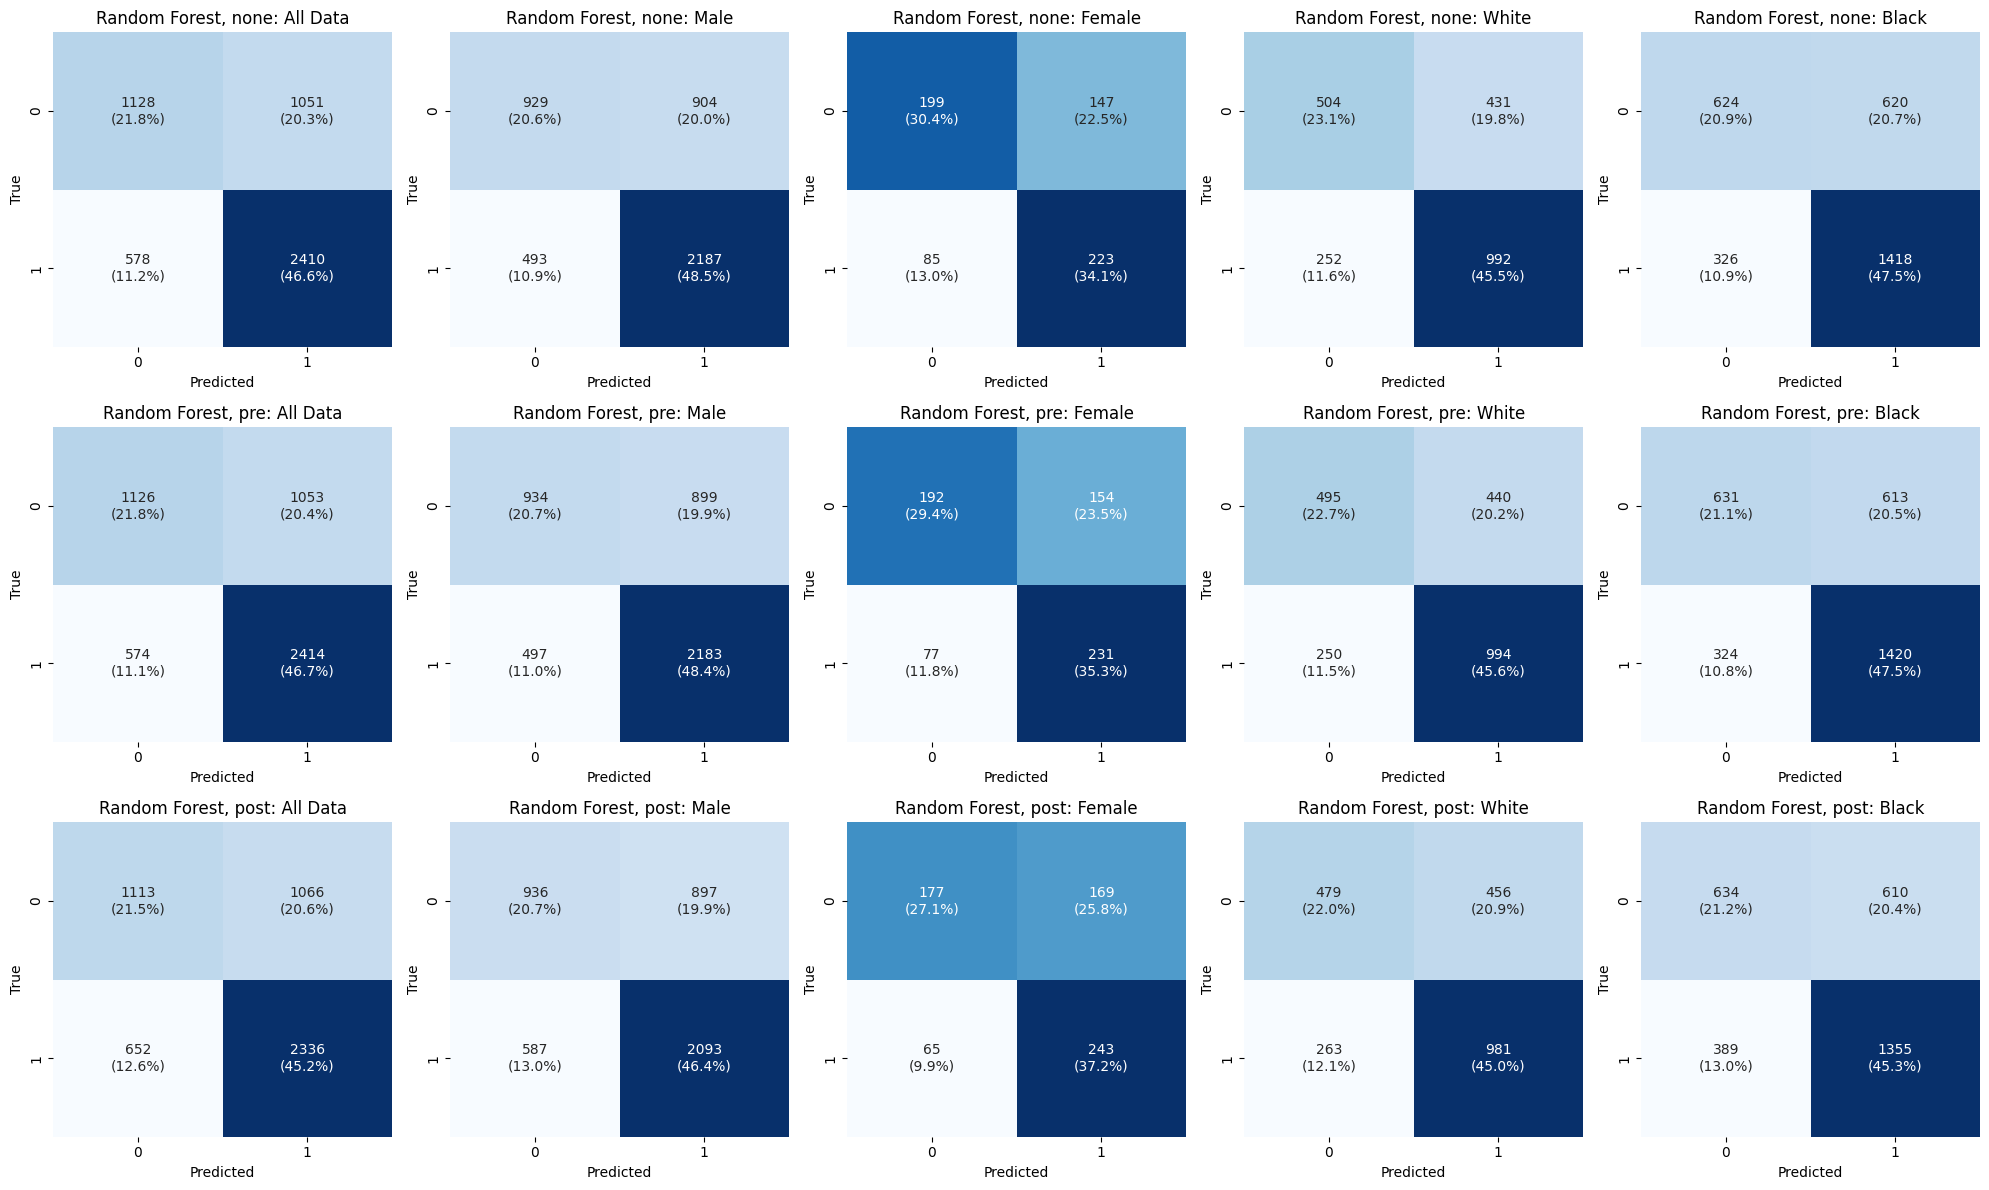

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows for 3 experiments

plot_confusion_matrices_stacked(y_test, y_hatRF, group_test_dict, 'Random Forest, none', axes[0])
plot_confusion_matrices_stacked(y_test, y_hatRF_pre, group_test_dict, 'Random Forest, pre', axes[1])
plot_confusion_matrices_stacked(y_test, y_hatRF_post, group_test_dict, 'Random Forest, post', axes[2])

plt.tight_layout()
plt.show()

## Blackstonian ratio

In [ ]:
from sklearn.metrics import confusion_matrix

def blackstonian_ratio(y_true, y_pred, group_dict):
    results = []

    for group_name, group_idx in group_dict.items():
        # Get group-specific true and predicted values
        y_true_group = y_true[group_idx]
        y_pred_group = y_pred[group_idx]
        
        # Confusion matrix
        cm = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1])
        
        tn, fp, fn, tp = cm.ravel()
        
        results.append({
            'Group': group_name,
            'TP': tp,
            'FP': fp,
            'Blackstonian ratio': tp/fp
        })

    return pd.DataFrame(results)

In [ ]:
def print_blackstonian_per_model(y_true, y_pred, group_dict, model_name, debiasing_type):
    df = blackstonian_ratio(y_true, y_pred, group_dict)
    print(f'\n{model_name} - {debiasing_type}')
    print(df[['Group', 'TP', 'FP', 'Blackstonian ratio']].to_string(index=False))

# Logistic Regression
print_blackstonian_per_model(y_test, y_hatLR, group_test_dict, 'LR', 'Baseline')
print_blackstonian_per_model(y_test, y_hatLR_pre, group_test_dict, 'LR', 'Pre-processing')
print_blackstonian_per_model(y_test, y_hatLR_post, group_test_dict, 'LR', 'Post-processing')

# Random Forest
print_blackstonian_per_model(y_test, y_hatRF, group_test_dict, 'RF', 'Baseline')
print_blackstonian_per_model(y_test, y_hatRF_pre, group_test_dict, 'RF', 'Pre-processing')
print_blackstonian_per_model(y_test, y_hatRF_post, group_test_dict, 'RF', 'Post-processing')



LR - Baseline
 Group   TP   FP  Blackstonian ratio
  Male 1679 1191            1.409740
Female  203  221            0.918552
 White  776  611            1.270049
 Black 1106  801            1.380774

LR - Pre-processing
 Group   TP  FP  Blackstonian ratio
  Male 2101 847            2.480519
Female  220 138            1.594203
 White  939 393            2.389313
 Black 1382 592            2.334459

LR - Post-processing
 Group   TP  FP  Blackstonian ratio
  Male 2037 823            2.475091
Female  235 155            1.516129
 White  948 422            2.246445
 Black 1324 556            2.381295

RF - Baseline
 Group   TP  FP  Blackstonian ratio
  Male 2187 904            2.419248
Female  223 147            1.517007
 White  992 431            2.301624
 Black 1418 620            2.287097

RF - Pre-processing
 Group   TP  FP  Blackstonian ratio
  Male 2183 899            2.428254
Female  231 154            1.500000
 White  994 440            2.259091
 Black 1420 613            2.316476

